In [699]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from statsmodels.api import OLS
from statsmodels.api import add_constant
import statsmodels.api as sm
import datetime

#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
from matplotlib import pyplot
default_dims = (13, 10)
import seaborn.apionly as sns #sets up styles and gives us more plotting options
sns.set_style("whitegrid")
sns.set_context("poster")
sns.reset_orig()

In [701]:
five_factor_df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', index_col = 'Date')
nan_rows = five_factor_df.isnull().T.any().T
five_factor_df = five_factor_df[~nan_rows]
print(np.shape(five_factor_df))
five_factor_df.head()

(13657, 6)


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
19630701,-0.67,0.00,-0.32,0.01,0.15,0.012
19630702,0.79,-0.27,0.27,-0.08,-0.19,0.012
19630703,0.63,-0.17,-0.09,0.19,-0.33,0.012
19630705,0.40,0.08,-0.28,0.07,-0.33,0.012
19630708,-0.63,0.04,-0.17,-0.31,0.13,0.012


In [702]:
five_factor_df.index = pd.to_datetime(five_factor_df.index,format='%Y%m%d')

In [703]:
three_factor_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col = 'Date')
nan_rows = three_factor_df.isnull().T.any().T
three_factor_df = three_factor_df[~nan_rows]
print(np.shape(three_factor_df))
three_factor_df.head()

(24077, 4)


,Mkt-RF,SMB,HML,RF
Date,,,,
19260701,0.10,-0.24,-0.28,0.009
19260702,0.45,-0.32,-0.08,0.009
19260706,0.17,0.27,-0.35,0.009
19260707,0.09,-0.59,0.03,0.009
19260708,0.21,-0.36,0.15,0.009


In [704]:
three_factor_df.index = pd.to_datetime(three_factor_df.index,format='%Y%m%d')

In [705]:
three_factors = [x for x in three_factor_df.columns if x != 'Date' and x != 'RF']
five_factors = [x for x in five_factor_df.columns if x != 'Date' and x != 'RF']

In [706]:
# stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE', 'AXLE']
stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE']

In [707]:
# quantities = [180, 110, 1000, 8000, 425, 2000]
quantities = [180, 110, 1000, 8000, 425]

In [708]:
ptf_dict = {stocks_held[i]: quantities[i] for i in range(len(quantities))}

In [709]:
dfs = []
for stock in stocks_held:
    stock_df = pd.read_csv('{}.csv'.format(stock), index_col = None)
    stock_df['Stock'] = stock
    dfs.append(stock_df)

# Adds in last dataframe at the end to keep them in order
df = pd.concat(dfs)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,7.5,7.5,7,7.125,7.125,1256400,USAK
1,1992-03-20,7.375,7.625,7.125,7.25,7.25,262800,USAK
2,1992-03-23,7.25,7.625,7.25,7.25,7.25,43800,USAK
3,1992-03-24,7.5,7.625,7.25,7.5,7.5,73600,USAK
4,1992-03-25,7.625,7.625,7.25,7.625,7.625,28000,USAK


In [710]:
df['Date'] = pd.to_datetime(df['Date'])

In [711]:
df = df.convert_objects(convert_numeric=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [712]:
df.index = range(len(df))
df['Open'] = [df['Open'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df['Close'] = [df['Close'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,1350.0,7.500,7.000,1282.5,7.125,1256400.0,USAK
1,1992-03-20,1327.5,7.625,7.125,1305.0,7.250,262800.0,USAK
2,1992-03-23,1305.0,7.625,7.250,1305.0,7.250,43800.0,USAK
3,1992-03-24,1350.0,7.625,7.250,1350.0,7.500,73600.0,USAK
4,1992-03-25,1372.5,7.625,7.250,1372.5,7.625,28000.0,USAK


In [776]:
df['Returns'] = np.log(df['Close']) - np.log(df['Open'])

In [777]:
df = df[df['Date'] >= datetime.datetime(2009, 9, 11)]

In [778]:
three_factor_df = three_factor_df[three_factor_df.index >= datetime.datetime(2009, 9, 11)]

In [779]:
five_factor_df = five_factor_df[five_factor_df.index >= datetime.datetime(2009, 9, 11)]

In [780]:
grouped_by_stock = df.groupby('Stock')

In [781]:
grouped_by_date = df.groupby('Date')

In [782]:
portfolio_values = grouped_by_date.sum()
portfolio_values.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2009-09-11,15094.50,22.97,22.19,15479.95,21.855906,725882.0,0.118931
2009-09-14,15180.00,19.30,18.40,15461.35,19.030000,543800.0,0.111881
2009-09-15,15318.10,19.29,18.54,15476.15,18.930000,397800.0,0.032476
2009-09-16,15921.00,23.33,22.55,15816.60,22.315906,498060.0,-0.001339
2009-09-17,15350.55,19.50,18.86,15783.15,19.220000,393800.0,0.056506


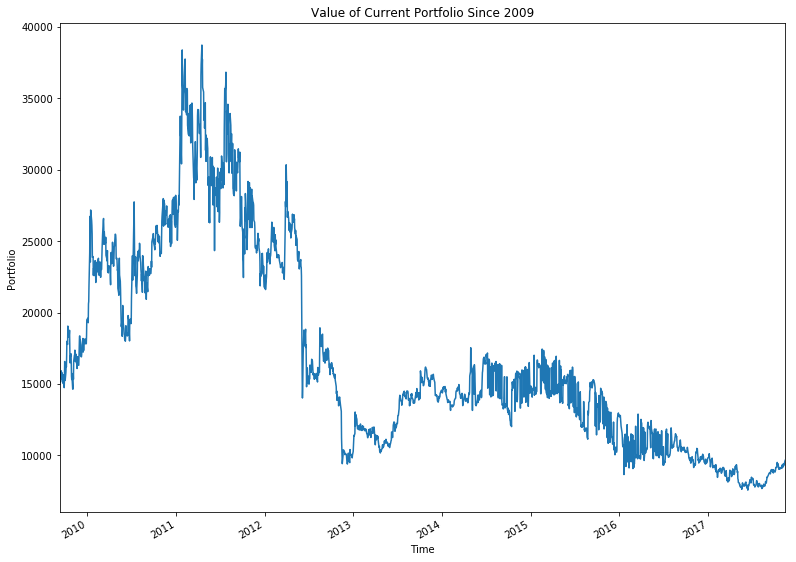

In [783]:
fig, ax = plt.subplots(figsize=default_dims)
portfolio_values['Open'].plot();
ax.set_xlabel('Time');
ax.set_ylabel('Portfolio');
ax.set_title('Value of Current Portfolio Since 2009');

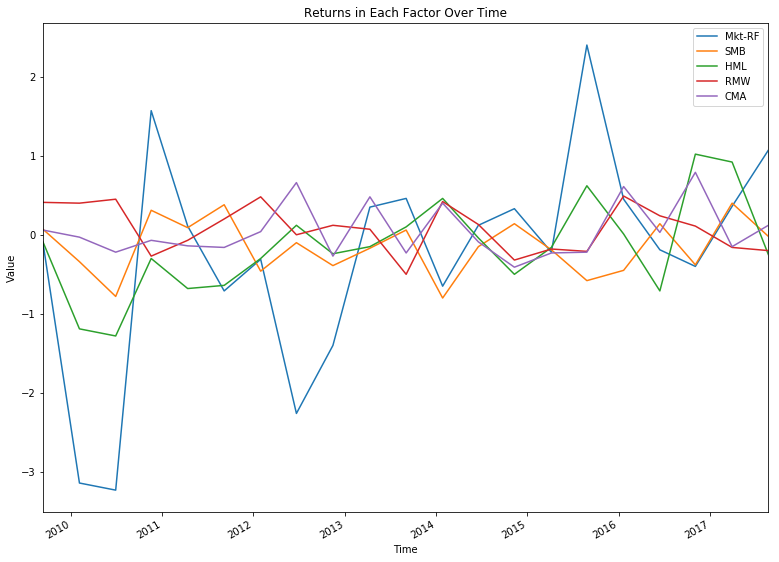

In [784]:
msk = [True if i % 100 ==0 else False for i in range(len(three_factor_df))]
fig, ax = plt.subplots(figsize=default_dims)
for factor in five_factors:
    five_factor_df[factor][msk].plot(legend = True);
ax.set_xlabel('Time');
ax.set_ylabel('Value');
ax.set_title('Returns in Each Factor Over Time');

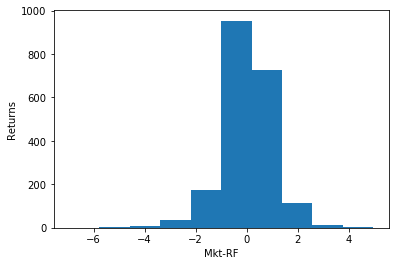

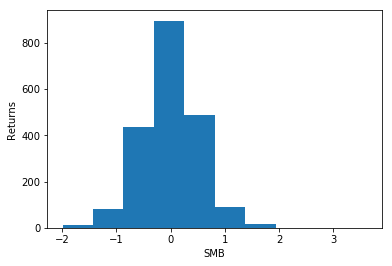

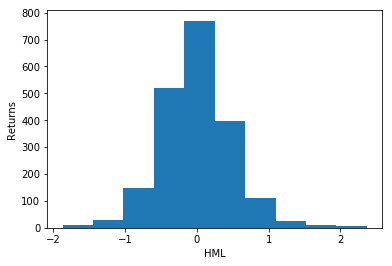

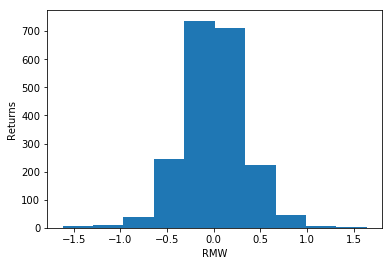

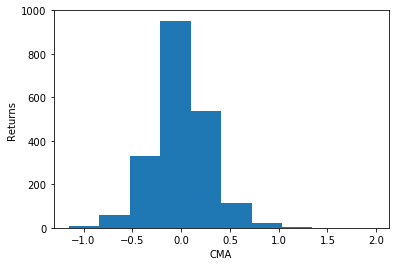

In [785]:
for factor in five_factors:
    fig, ax = pyplot.subplots()
    plt.hist(five_factor_df[factor])
    ax.set_xlabel(factor);
    ax.set_ylabel('Returns');

In [786]:
three_factors

['Mkt-RF', 'SMB', 'HML']

**In-sample evaluation**

In [787]:
df_three = pd.concat([portfolio_values, three_factor_df], axis=1, join='inner')

In [788]:
df_five = pd.concat([portfolio_values, five_factor_df], axis=1, join='inner')

In [789]:
x_three = df_three[three_factors]

In [790]:
x_five = df_five[five_factors]

In [791]:
y = df_three['Returns']

In [792]:
three_factor_OLS = sm.OLS(y, x_three.values)
three_factor_results = three_factor_OLS.fit()
three_factor_results.summary(xname = three_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     82.16
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           3.67e-50
Time:                        09:25:07   Log-Likelihood:                 1945.8
No. Observations:                2028   AIC:                            -3886.
Df Residuals:                    2025   BIC:                            -3869.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0205      0.002      8.576      0.000       0.016       0.025
SMB            0.0343      0.004      8.001      0.000       0.026       0.043
HML            0.0074      0.004      1.703      0.089      -0.001       0.016
==============================================================================
Omnibus:                     1042.026   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36476.619
Skew:                           1.778   Prob(JB):                         0.00
Kurtosis:                      23.470   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [793]:
five_factor_OLS = sm.OLS(y, x_five.values)
five_factor_results = five_factor_OLS.fit()
five_factor_results.summary(xname = five_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     53.16
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           5.74e-52
Time:                        09:25:08   Log-Likelihood:                 1954.5
No. Observations:                2028   AIC:                            -3899.
Df Residuals:                    2023   BIC:                            -3871.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0234      0.003      9.105      0.000       0.018       0.028
SMB            0.0364      0.004      8.114      0.000       0.028       0.045
HML           -0.0055      0.006     -0.984      0.325      -0.016       0.005
RMW            0.0124      0.007      1.659      0.097      -0.002       0.027
CMA            0.0302      0.009      3.343      0.001       0.012       0.048
==============================================================================
Omnibus:                     1061.255   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38251.625
Skew:                           1.818   Prob(JB):                         0.00
Kurtosis:                      23.963   Cond. No.                         4.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [794]:
capm_df = pd.read_csv('SPY.csv',index_col = 'Date')

In [795]:
capm_df.index = pd.to_datetime(capm_df.index)

In [796]:
df_train_capm = portfolio_values
df_train_capm['Market'] = np.log(capm_df['Close']) - np.log(capm_df['Open'])

In [797]:
x_capm = df_train_capm['Market']
y_capm = df_train_capm['Returns']

In [798]:
capm_OLS = sm.OLS(y_capm, x_capm)
capm_results = capm_OLS.fit()
capm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     225.2
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           2.20e-48
Time:                        09:25:16   Log-Likelihood:                 1976.4
No. Observations:                2061   AIC:                            -3951.
Df Residuals:                    2060   BIC:                            -3945.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Market         4.3173      0.288     15.006      0.000       3.753       4.882
==============================================================================
Omnibus:                      976.092   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29296.292
Skew:                           1.621   Prob(JB):                         0.00
Kurtosis:                      21.184   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Out-of-sample evaluation**

In [799]:
def split(x,y):
    np.random.seed(9001)
    msk = np.random.rand(len(x)) < .75
    return x[msk], x[~msk], y[msk], y[~msk]

In [800]:
x_train_three, x_test_three, y_train, y_test = split(x_three, y)

In [801]:
three_factor_OLS = sm.OLS(y_train, x_train_three.values)
results_sm = three_factor_OLS.fit()
print('Three factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_three.values))))

Three factor test r2 of 0.12050916425090707


In [802]:
x_train_five, x_test_five, y_train, y_test = split(x_five, y)

In [803]:
five_factor_OLS = sm.OLS(y_train, x_train_five.values)
results_sm = five_factor_OLS.fit()
print('Five factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_five.values))))

Five factor test r2 of 0.12595466382666898


In [804]:
x_train_capm, x_test_capm, y_train_capm, y_test_capm = split(x_capm, y_capm)

In [805]:
capm_OLS = sm.OLS(y_train_capm, x_train_capm.values)
results_sm = capm_OLS.fit()
print('CAPM test r2 of {}'.format(r2_score(y_test_capm, results_sm.predict(x_test_capm.values))))

CAPM test r2 of 0.1306707400174345


**EDA for Value Factor**

In [806]:
value_df = pd.read_csv('RZV.csv', index_col = 'Date')

In [807]:
value_df.index = pd.to_datetime(value_df.index)

In [808]:
df_value = portfolio_values
df_value['Value'] = np.log(value_df['Close']) - np.log(value_df['Open'])
df_value = df_value.dropna()

In [809]:
x_value = df_value['Value']
y_value = df_value['Returns']

In [810]:
value_OLS = sm.OLS(y_value, x_value)
value_results = value_OLS.fit()
value_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     133.1
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           1.34e-29
Time:                        09:25:34   Log-Likelihood:                 1565.6
No. Observations:                1557   AIC:                            -3129.
Df Residuals:                    1556   BIC:                            -3124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Value          2.3535      0.204     11.536      0.000       1.953       2.754
==============================================================================
Omnibus:                      885.945   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49205.855
Skew:                           1.902   Prob(JB):                         0.00
Kurtosis:                      30.276   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [811]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of 0.0679348059461744


In [812]:
x_value = df_five['SMB']
y_value = df_five['Returns']

In [813]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of 0.07922111202152493


In [842]:
for stock in stocks_held:
    stock_group = grouped_by_stock.get_group(stock).groupby('Date').sum()
    temp_df = pd.concat([stock_group, five_factor_df], axis=1, join='inner').dropna()
    x = temp_df[five_factors]
    y = temp_df['Returns']
    x_train, x_test, y_train, y_test = split(x, y)
    OLS = sm.OLS(y_train, x_train)
    results = OLS.fit()
    print(results.summary(title=stock))

                                     USAK                                     
Dep. Variable:                Returns   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     25.91
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           3.59e-25
Time:                        09:32:46   Log-Likelihood:                 3232.6
No. Observations:                1523   AIC:                            -6455.
Df Residuals:                    1518   BIC:                            -6429.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0034      0.001      3.721      0.0